## Dimensionality Reduction in Python

In [2]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [12]:
NAC_data = 'NAC_data.csv'
file = pd.read_csv(NAC_data)
NAC_df = pd.DataFrame(file)

# Select the perceived most important performance metrics for a striker
NAC_df_selected = NAC_df[['Position', 'Goals', 'Assists', 'Shots on target, %', 'Goal conversion, %', 'xG', 'Aerial duels won, %', 'Accurate passes, %']]

In [14]:
# Split the column by comma
NAC_df_selected['Position'] = NAC_df_selected['Position'].str.split(',')

exploded_df = NAC_df_selected.explode('Position')

# Reset the index
exploded_df.reset_index(drop=True, inplace=True)

print(exploded_df)

      Position  Goals  Assists  Shots on target, %  Goal conversion, %     xG  \
0           CF     30        6               58.42              29.703  21.11   
1          DMF      2        3               32.00               8.000   1.99   
2         RDMF      2        3               32.00               8.000   1.99   
3         RCMF      2        3               32.00               8.000   1.99   
4           CF     17        4               50.75              25.373  14.33   
...        ...    ...      ...                 ...                 ...    ...   
32698     LDMF      0        3               14.29               0.000   0.27   
32699      RCB      0        0                0.00               0.000   0.00   
32700      LCB      0        0                0.00               0.000   0.00   
32701       CF      2        0               75.00              25.000   1.11   
32702       RW      2        0               75.00              25.000   1.11   

       Aerial duels won, % 

/var/folders/kt/2vh50bcn2x7f6zgfl_5r2mhm0000gn/T/ipykernel_67890/2664551599.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NAC_df_selected['Position'] = NAC_df_selected['Position'].str.split(',')


In [16]:
cf_players = exploded_df[exploded_df['Position'] == 'CF']
cf_players

,Position,Goals,Assists,"Shots on target, %","Goal conversion, %",xG,"Aerial duels won, %","Accurate passes, %"
0,CF,30,6,58.42,29.703,21.11,42.22,77.91
4,CF,17,4,50.75,25.373,14.33,36.73,73.98
7,CF,3,6,34.29,4.286,4.57,31.43,67.74
10,CF,9,3,37.50,16.071,7.92,40.32,72.89
14,CF,10,4,48.78,12.195,12.55,35.71,73.10
...,...,...,...,...,...,...,...,...
32584,CF,1,0,33.33,16.667,0.35,53.57,60.94
32617,CF,2,0,50.00,33.333,1.28,38.46,72.00
32644,CF,1,2,66.67,16.667,0.27,15.38,73.79
32674,CF,0,0,0.00,0.000,0.99,37.21,69.11


## Feature Extraction

### Visually detecting redundant features

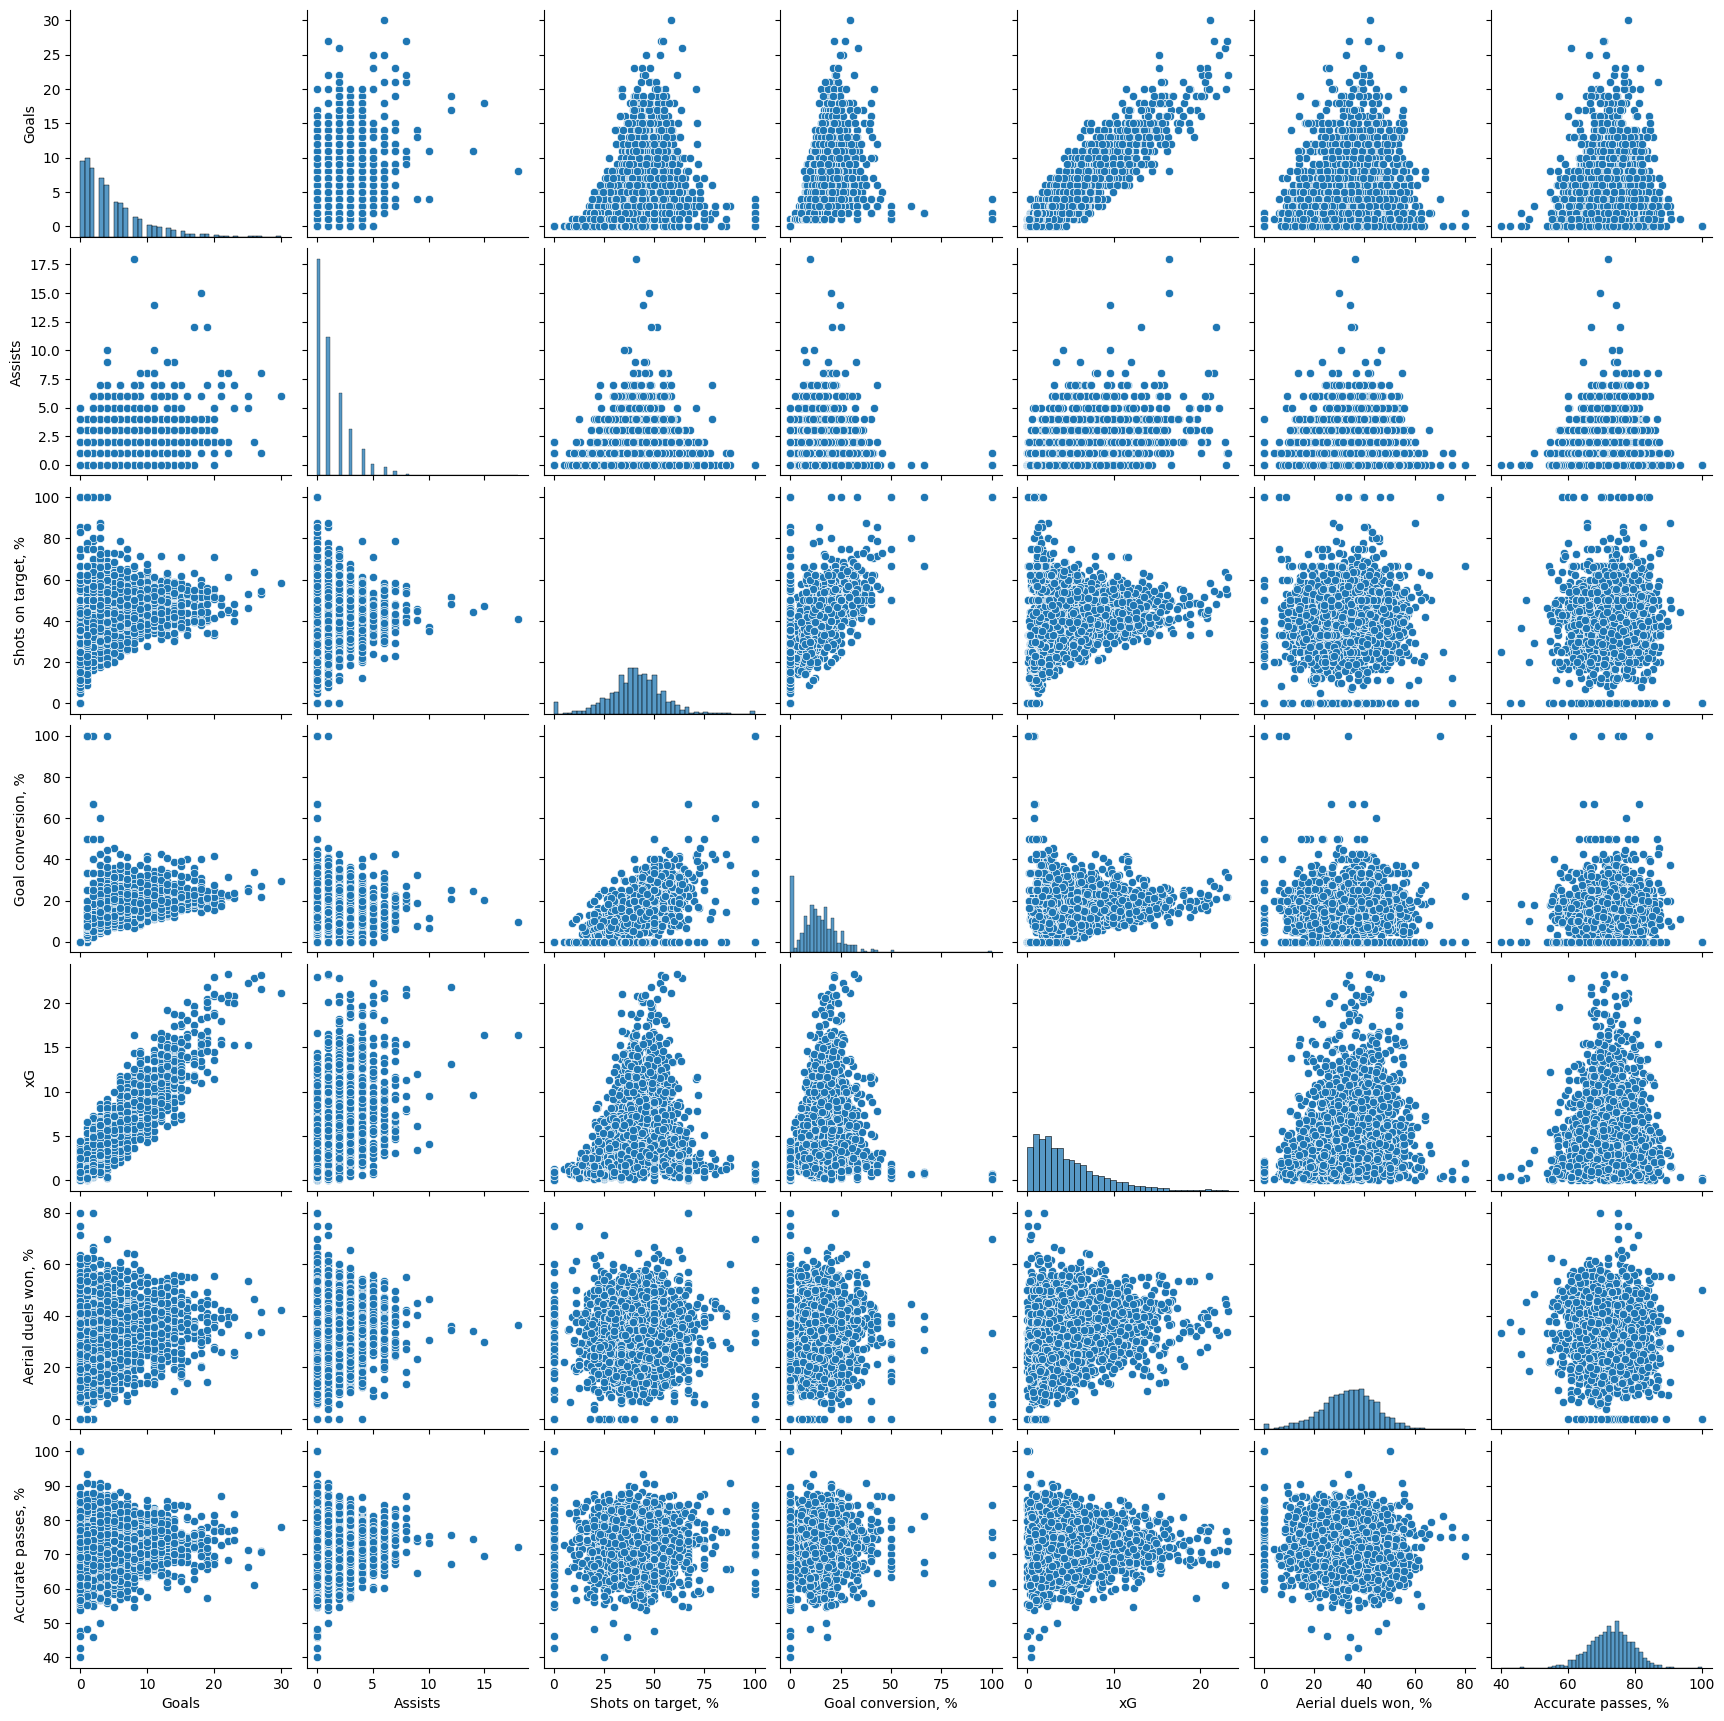

In [17]:
# Create a pairplot and color the points using the 'Gender' feature
sns.pairplot(cf_players, diag_kind='hist')

# Show the plot
plt.show()

_All selected features have high variance. Therefore, no need for dropping for now._

### t-SNE visualisation

In [20]:
from sklearn.manifold import TSNE

# Non-numerical columns in the dataset
non_numeric = ['Player', 'Team', 'Team within selected timeframe','Position', 'Contract expires', 'Birth country', 'Passport country', 'Foot', 'On loan']

# Drop the non-numerical columns from df
df_numeric = NAC_df.drop(non_numeric, axis=1)

# Create a t-SNE model with learning rate 50
m = TSNE(learning_rate = 50)

# Handle NaN values using a simple imputer
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(df_numeric), columns=df_numeric.columns)

# Fit and transform the t-SNE model on the numeric dataset
tsne_features = m.fit_transform(X_imputed)
print(tsne_features.shape)

# Create a dataframne with the tsne features
df_tsne = pd.DataFrame(tsne_features, columns=['tsne_x', 'tsne_y'])

(16535, 2)


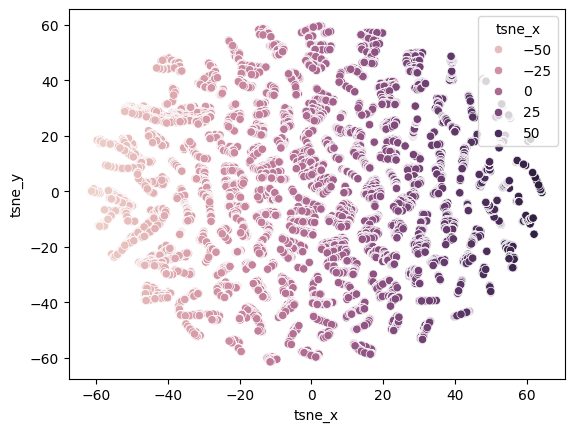

In [61]:
# Color the points by Gender
sns.scatterplot(x="tsne_x", y="tsne_y", hue= 'tsne_x', data=df_tsne)

# Show the plot
plt.show()

### Removing features with many missing values

In [34]:
NAC_df.isna().sum()/len(NAC_df)

Unnamed: 0                        0.000000
Player                            0.000000
Team                              0.037799
Team within selected timeframe    0.000000
Position                          0.003387
                                    ...   
Direct free kicks per 90          0.091321
Direct free kicks on target, %    0.091321
Corners per 90                    0.014031
Penalties taken                   0.000000
Penalty conversion, %             0.000000
Length: 115, dtype: float64

In [38]:
# Create a boolean mask on whether each feature less than 10% missing values.
mask = NAC_df.isna().sum() / len(NAC_df) < 0.1
print(mask)

Unnamed: 0                        True
Player                            True
Team                              True
Team within selected timeframe    True
Position                          True
                                  ... 
Direct free kicks per 90          True
Direct free kicks on target, %    True
Corners per 90                    True
Penalties taken                   True
Penalty conversion, %             True
Length: 115, dtype: bool


### Correlation

In [43]:
X_imputed.corr()

,Unnamed: 0,Age,Market value,Matches played,Minutes played,Goals,xG,Assists,xA,Duels per 90,...,Prevented goals per 90,Back passes received as GK per 90,Exits per 90,Aerial duels per 90.1,Free kicks per 90,Direct free kicks per 90,"Direct free kicks on target, %",Corners per 90,Penalties taken,"Penalty conversion, %"
Unnamed: 0,1.000000,-0.080724,0.040404,-0.037411,-0.021898,-0.005421,-0.004963,0.002184,-0.002638,0.011666,...,2.887624e-05,0.039023,-1.167788e-02,2.064388e-03,-0.026370,-0.023612,-0.004841,-0.011432,-0.006248,-0.003952
Age,-0.080724,1.000000,0.007133,0.168505,0.207519,0.059930,0.084176,0.064584,0.084681,-0.176971,...,2.834116e-02,0.030915,-9.077747e-03,-2.174439e-02,0.107643,0.076456,0.058012,0.069148,0.117906,0.111885
Market value,0.040404,0.007133,1.000000,0.117739,0.140969,0.180432,0.177166,0.170898,0.175296,0.002192,...,1.590480e-02,0.002885,-1.018415e-02,-1.073339e-02,0.024014,0.033369,0.047075,0.070282,0.098458,0.084370
Matches played,-0.037411,0.168505,0.117739,1.000000,0.878492,0.400776,0.436774,0.391606,0.455612,0.078670,...,8.527745e-02,-0.028690,-5.963127e-04,-2.689184e-03,0.071370,0.061040,0.102648,0.076574,0.203404,0.173521
Minutes played,-0.021898,0.207519,0.140969,0.878492,1.000000,0.331066,0.352149,0.346969,0.405205,-0.161394,...,8.836354e-02,0.112143,-2.132844e-03,-3.768464e-03,0.050868,0.035392,0.098954,0.021283,0.197818,0.146162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Direct free kicks per 90,-0.023612,0.076456,0.033369,0.061040,0.035392,0.171620,0.144653,0.243070,0.316512,0.008829,...,-5.250922e-18,-0.140966,-2.309078e-16,-1.607026e-16,0.700753,1.000000,0.462641,0.555582,0.204678,0.210257
"Direct free kicks on target, %",-0.004841,0.058012,0.047075,0.102648,0.098954,0.147119,0.134635,0.202250,0.260638,-0.007152,...,2.938505e-18,-0.094044,3.632579e-17,-8.854059e-17,0.403902,0.462641,1.000000,0.366430,0.145881,0.153017
Corners per 90,-0.011432,0.069148,0.070282,0.076574,0.021283,0.122083,0.090270,0.400787,0.555019,0.068928,...,5.335890e-07,-0.157369,1.289399e-05,1.823908e-05,0.823381,0.555582,0.366430,1.000000,0.149689,0.168460
Penalties taken,-0.006248,0.117906,0.098458,0.203404,0.197818,0.595402,0.630288,0.276660,0.302197,0.135376,...,3.433890e-18,-0.128492,2.607832e-16,-2.275714e-16,0.156831,0.204678,0.145881,0.149689,1.000000,0.729126


### Recursive Feature Elimination

In [51]:
# Splitting the dataset into testing and training sets
X = NAC_df[[ 'Age', 'xG', 'Duels per 90', 'Height', 'Assists per 90']]
y = NAC_df['Goals']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Using one-hot encoding for adressing categorical data
X_train_encoded = pd.get_dummies(X_train)
X_test_encoded = pd.get_dummies(X_test)

# Handling NaN values using a simple imputer
imputer = SimpleImputer(strategy='mean')
X_train_encoded = pd.DataFrame(imputer.fit_transform(X_train_encoded), columns=X_train_encoded.columns)
X_test_encoded = pd.DataFrame(imputer.transform(X_test_encoded), columns=X_test_encoded.columns)\

# Instantiating and fitting the model
log_reg = LogisticRegression(max_iter=100000)
log_reg.fit(X_train_encoded, y_train)

# Predict on the test set
y_pred = log_reg.predict(X_test_encoded)

/Users/daria/anaconda3/envs/block_b/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [47]:
from sklearn.metrics import accuracy_score
print(f"{accuracy_score(y_test, y_pred):.1%} accuracy on test set.")
print(dict(zip(X.columns, abs(log_reg.coef_[0]))))

53.1% accuracy on test set.
{'Age': 0.25108057522885896, 'xG': 4.6839925077062325, 'Duels per 90': 0.18009977808956287, 'Height': 0.0064044251436994526, 'Assists per 90': 1.9743691526167124}


Running the code again after removing one feature with the lowest model coefficient.

In [48]:
# Splitting the dataset into testing and training sets
X = NAC_df[[ 'Age', 'xG', 'Duels per 90', 'Assists per 90']]
y = NAC_df['Goals']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Using one-hot encoding for adressing categorical data
X_train_encoded = pd.get_dummies(X_train)
X_test_encoded = pd.get_dummies(X_test)

# Handling NaN values using a simple imputer
imputer = SimpleImputer(strategy='mean')
X_train_encoded = pd.DataFrame(imputer.fit_transform(X_train_encoded), columns=X_train_encoded.columns)
X_test_encoded = pd.DataFrame(imputer.transform(X_test_encoded), columns=X_test_encoded.columns)\

# Instantiating and fitting the model
log_reg = LogisticRegression(max_iter=100000)
log_reg.fit(X_train_encoded, y_train)

# Predict on the test set
y_pred = log_reg.predict(X_test_encoded)

print(f"{accuracy_score(y_test, y_pred):.1%} accuracy on test set.")
print(dict(zip(X.columns, abs(log_reg.coef_[0]))))

53.3% accuracy on test set.
{'Age': 0.14838610351561118, 'xG': 4.6607267380644775, 'Duels per 90': 0.10694112793992751, 'Assists per 90': 2.0470158445940343}


_Accuracy has not decreased by much_

Running the code again after removing two features with the lowest model coefficient.

In [49]:
# Splitting the dataset into testing and training sets
X = NAC_df[['xG','Assists per 90']]
y = NAC_df['Goals']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Using one-hot encoding for adressing categorical data
X_train_encoded = pd.get_dummies(X_train)
X_test_encoded = pd.get_dummies(X_test)

# Handling NaN values using a simple imputer
imputer = SimpleImputer(strategy='mean')
X_train_encoded = pd.DataFrame(imputer.fit_transform(X_train_encoded), columns=X_train_encoded.columns)
X_test_encoded = pd.DataFrame(imputer.transform(X_test_encoded), columns=X_test_encoded.columns)\

# Instantiating and fitting the model
log_reg = LogisticRegression(max_iter=100000)
log_reg.fit(X_train_encoded, y_train)

# Predict on the test set
y_pred = log_reg.predict(X_test_encoded)

print(f"{accuracy_score(y_test, y_pred):.1%} accuracy on test set.")
print(dict(zip(X.columns, abs(log_reg.coef_[0]))))

53.2% accuracy on test set.
{'xG': 4.700995314759897, 'Assists per 90': 2.284407432184303}


Running the code with only one feature

In [50]:
# Splitting the dataset into testing and training sets
X = NAC_df[['xG']]
y = NAC_df['Goals']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Using one-hot encoding for adressing categorical data
X_train_encoded = pd.get_dummies(X_train)
X_test_encoded = pd.get_dummies(X_test)

# Handling NaN values using a simple imputer
imputer = SimpleImputer(strategy='mean')
X_train_encoded = pd.DataFrame(imputer.fit_transform(X_train_encoded), columns=X_train_encoded.columns)
X_test_encoded = pd.DataFrame(imputer.transform(X_test_encoded), columns=X_test_encoded.columns)\

# Instantiating and fitting the model
log_reg = LogisticRegression(max_iter=100000)
log_reg.fit(X_train_encoded, y_train)

# Predict on the test set
y_pred = log_reg.predict(X_test_encoded)

print(f"{accuracy_score(y_test, y_pred):.1%} accuracy on test set.")
print(dict(zip(X.columns, abs(log_reg.coef_[0]))))

52.8% accuracy on test set.
{'xG': 4.726333372573956}


Now using a RFE

In [54]:
X_train.isna().sum()

Age                 5
xG                  0
Duels per 90      183
Height              0
Assists per 90    183
dtype: int64

In [67]:
from sklearn.feature_selection import RFE

# Create the RFE with a LogisticRegression estimator and 3 features to select
rfe = RFE(estimator=LogisticRegression(), n_features_to_select=3, verbose=1)

# Fits the eliminator to the data
rfe.fit(X_imputed, y_train)

# Print the features and their ranking (high = dropped early on)
print(dict(zip(X_imputed.columns, rfe.ranking_)))

# Print the features that are not eliminated
print(X_imputed.columns[rfe.support_])

# Calculates the test set accuracy
acc = accuracy_score(y_test, rfe.predict(X_test))
print(f"{acc:.1%} accuracy on test set.") 

ValueError: Found input variables with inconsistent numbers of samples: [16535, 13228]

### Random Forest Classifier

In [71]:
from sklearn.ensemble import RandomForestClassifier

# Fit the random forest model to the training data
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train_encoded)

# Calculate the accuracy
acc = accuracy_score(y_test, rf.predict(X_test))

# Print the importances per feature
print(dict(zip(X.columns, rf.feature_importances_.round(2))))

# Print accuracy
print(f"{acc:.1%} accuracy on test set.") 

TypeError: fit() missing 1 required positional argument: 'y'

### Principal Component Analysis

In [57]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Create the scaler
scaler = StandardScaler()
NAC_std = scaler.fit_transform(X_imputed)

# Create the PCA instance and fit and transform the data with pca
pca = PCA()
pc = pca.fit_transform(NAC_std)
pc_df = pd.DataFrame(pc, columns=['PC 1', 'PC 2', 'PC 3', 'PC 4'])

# Create a pairplot of the principal component DataFrame
sns.pairplot(pc_df)
plt.show()

ValueError: Shape of passed values is (16535, 106), indices imply (16535, 4)